In [ ]:
# -*- coding: utf-8 -*-
"""
Replicação Seção 6.2 do paper:
- GA + XGBRegressor para prever CAR_30D
- Ranking por previsão dentro de cada trimestre
- Moving portfolios de 100 ações (Fig. 3)
- Portfólios por quantis (Q1–Q5)
- Loop automático para todos os trimestres 2017–2019

Pré-requisito:
  - Diretório pead_preproc com:
        train_processed.csv (2010–2016)
        test_processed.csv  (2017–2019)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [20]:
FEATS = [

    # ===== Fundamental – níveis MET =====
    "RL_MET", "LL_MET", "EBITDA_MET",
    "Preco_Abertura_MET", "Preco_Fechamento_MET",
    "LPA_MET", "ROA_MET", "ROE_MET", "MEB_MET",
    "CRESC_RL_12M_MET", "CRESC_LL_12M_MET", "CRESC_EBITDA_12M_MET",
    "CAPEX_MET", "FCO_MET", "FCF_MET",
    "Divida_Liquida_MET", "PL_MET", "Divida_Bruta_MET",
    "AT_MET", "DVA_Despesas_Fin_MET",
    "PC_MET", "PNC_MET", "Outros_PC_MET",
    "LUB_MET",

    # ===== Fundamental – variações Q (quarter-over-quarter) =====
    "RL_Q_Change", "LL_Q_Change", "EBITDA_Q_Change",
    "Preco_Abertura_Q_Change", "Preco_Fechamento_Q_Change",
    "LPA_Q_Change", "ROA_Q_Change", "ROE_Q_Change", "MEB_Q_Change",
    "CRESC_RL_12M_Q_Change", "CRESC_LL_12M_Q_Change", "CRESC_EBITDA_12M_Q_Change",
    "CAPEX_Q_Change", "FCO_Q_Change", "FCF_Q_Change",
    "Divida_Liquida_Q_Change", "PL_Q_Change", "Divida_Bruta_Q_Change",
    "AT_Q_Change", "DVA_Despesas_Fin_Q_Change",
    "PC_Q_Change", "PNC_Q_Change", "Outros_PC_Q_Change",
    "LUB_Q_Change",

    # ===== Fundamental – variações Y (year-over-year) =====
    "RL_Y_Change", "LL_Y_Change", "EBITDA_Y_Change",
    "Preco_Abertura_Y_Change", "Preco_Fechamento_Y_Change",
    "LPA_Y_Change", "ROA_Y_Change", "ROE_Y_Change", "MEB_Y_Change",
    "CRESC_RL_12M_Y_Change", "CRESC_LL_12M_Y_Change", "CRESC_EBITDA_12M_Y_Change",
    "CAPEX_Y_Change", "FCO_Y_Change", "FCF_Y_Change",
    "Divida_Liquida_Y_Change", "PL_Y_Change", "Divida_Bruta_Y_Change",
    "AT_Y_Change", "DVA_Despesas_Fin_Y_Change",
    "PC_Y_Change", "PNC_Y_Change", "Outros_PC_Y_Change",
    "LUB_Y_Change",

    # ===== EPS Surprise Features =====
    "EPS_EarningsSurprise",
    "EPS_Earnings_Surprise_Backward_Diff",
    "EPS_Earnings_Surprise_Backward_Ave_Diff",

    # ===== Momentum & Technical Indicators =====
    "MA5", "MA50", "MA200",
    "RSI9", "RSI14", "RSI30",
    "MA5_50", "MA5_200", "MA50_200",
    "MOM_1M", "MOM_3M", "MOM_6M", "MOM_12M",
]


In [ ]:
# -------------------- CONFIGURAÇÕES --------------------
BASE_PRE  = "pead_preproc"
TRAIN_CSV = os.path.join(BASE_PRE, "train_processed.csv")
TEST_CSV  = os.path.join(BASE_PRE, "test_processed.csv")

OUT_DIR   = "results_6_2"
FIG_DIR   = os.path.join(OUT_DIR, "figures")
CSV_DIR   = os.path.join(OUT_DIR, "csv")

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

# Anos que você quer testar (equivalente a 2015–2018 do paper)
YEARS = [2017, 2018, 2019]

In [ ]:
# -------------------- CARREGAR DADOS PRÉ-PROCESSADOS --------------------
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)
df_all   = pd.concat([df_train, df_test], ignore_index=True)

df_all["EventTradeDate"] = pd.to_datetime(df_all["EventTradeDate"])
df_all["Year"]    = df_all["EventTradeDate"].dt.year
df_all["Quarter"] = df_all["EventTradeDate"].dt.quarter  # 1..4

In [ ]:
# -------------------- GA PARA XGBRegressor (Seção 6.2, Fig. 2) --------------------
def ga_optimize_xgb_reg(X_train, y_train, generations=5, pop_size=10, verbose=False):
    """
    GA + 5-fold CV para XGBRegressor.
    Fitness = RMSE médio (quanto menor, melhor).
    Compatível com versões antigas do sklearn (sem 'squared' em mean_squared_error).
    """

    SEARCH_SPACE = {
        "max_depth":        [3,4,5,6,7],
        "learning_rate":    [0.01, 0.03, 0.05, 0.07, 0.1],
        "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
        "min_child_weight": [1,2,3,5,7],
        "gamma":            [0, 0.01, 0.05, 0.1, 0.2],
    }

    def random_params():
        return {k: np.random.choice(v) for k, v in SEARCH_SPACE.items()}

    def fitness(params):
        kf = KFold(n_splits=5, shuffle=True)
        rmses = []

        for tr, va in kf.split(X_train):
            model = XGBRegressor(
                n_estimators=200,
                objective="reg:squarederror",
                **params
            )
            model.fit(X_train[tr], y_train[tr])
            pred = model.predict(X_train[va])

            # RMSE compatível com qualquer versão do sklearn
            mse  = mean_squared_error(y_train[va], pred)
            rmse = np.sqrt(mse)
            rmses.append(rmse)

        return np.mean(rmses)  # menor = melhor

    # População inicial
    population = [random_params() for _ in range(pop_size)]

    for gen in range(generations):
        if verbose:
            print(f"[GA-REG] geração {gen+1}/{generations}", flush=True)

        scores = [fitness(p) for p in population]          # RMSEs
        ranked = sorted(zip(scores, population), key=lambda x: x[0])
        survivors = [p for _, p in ranked[:pop_size // 2]] # menores RMSE

        # Reprodução
        children = []
        while len(children) < pop_size - len(survivors):
            p1, p2 = np.random.choice(survivors, 2, replace=True)
            child = {}
            for k in SEARCH_SPACE:
                child[k] = p1[k] if np.random.rand() < 0.5 else p2[k]
            # Mutação segura
            if np.random.rand() < 0.2:
                mut_key = np.random.choice(list(SEARCH_SPACE.keys()))
                child[mut_key] = np.random.choice(SEARCH_SPACE[mut_key])
            children.append(child)

        population = survivors + children

    final_scores = [fitness(p) for p in population]
    best_params  = population[int(np.argmin(final_scores))]

    if verbose:
        print("[GA-REG] melhor RMSE:", min(final_scores))
        print("[GA-REG] best_params:", best_params)

    return best_params

In [ ]:
# -------------------- TESTE POR ANO + TRIMESTRE (Seção 6.2) --------------------
def run_quarter_portfolio_test(year, quarter, use_ga=True):
    """
    Implementa a estratégia da Seção 6.2 para um ano/trimestre.
    Retorna:
      df_q_sorted : DataFrame dos eventos no trimestre com CAR_30D real e CAR_pred
      curve_df    : curva de moving portfolios (Fig. 3)
      quant_df    : retornos médios por quantil (Q1..Q5)
    """

    # Eventos do trimestre
    mask_q = (df_all["Year"] == year) & (df_all["Quarter"] == quarter)
    df_q = df_all.loc[mask_q].copy()

    if df_q.empty:
        print(f"[{year} Q{quarter}] Sem eventos, ignorando.")
        return None, None, None

    # Data mínima do trimestre → treino só com histórico anterior
    quarter_start = df_q["EventTradeDate"].min()
    mask_train = df_all["EventTradeDate"] < quarter_start
    df_train_q = df_all.loc[mask_train].copy()

    if df_train_q.empty:
        print(f"[{year} Q{quarter}] Sem histórico anterior suficiente.")
        return None, None, None

    X_train = df_train_q[FEATS].to_numpy()
    y_train = df_train_q["CAR_30D"].to_numpy()

    X_test  = df_q[FEATS].to_numpy()
    y_test  = df_q["CAR_30D"].to_numpy()

    if use_ga:
        best_params = ga_optimize_xgb_reg(
            X_train, y_train,
            generations=5, pop_size=10,
            verbose=True
        )
    else:
        best_params = {
            "max_depth": 5,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_weight": 3,
            "gamma": 0.05,
        }

    model = XGBRegressor(
        n_estimators=300,
        objective="reg:squarederror",
        **best_params
    )
    model.fit(X_train, y_train)

    # Previsão de CAR_30D
    df_q["CAR_pred"] = model.predict(X_test)

    # Ordena do maior para o menor (pré-ranking pelo modelo)
    df_q_sorted = df_q.sort_values("CAR_pred", ascending=False).reset_index(drop=True)

    # -------- Moving portfolios de 100 ações (Fig. 3) --------
    window = 100
    if len(df_q_sorted) < window:
        print(f"[{year} Q{quarter}] Apenas {len(df_q_sorted)} eventos, usando janela {len(df_q_sorted)}.")
        window = len(df_q_sorted)

    port_returns = []
    port_index   = []

    for start in range(0, len(df_q_sorted) - window + 1):
        subset = df_q_sorted.iloc[start:start+window]
        avg_car = subset["CAR_30D"].mean()
        port_returns.append(avg_car)
        port_index.append(start + 1)

    curve_df = pd.DataFrame({
        "RankStart": port_index,
        "AvgCAR30": port_returns
    })

    # -------- Portfólios por quantis (Q1..Q5) --------
    df_q_sorted["Rank"] = np.arange(1, len(df_q_sorted)+1)
    df_q_sorted["Quantile5"] = pd.qcut(df_q_sorted["Rank"], 5, labels=False) + 1  # 1..5

    quant_rows = []
    for q in range(1, 6):
        sub = df_q_sorted[df_q_sorted["Quantile5"] == q]
        if len(sub) == 0:
            continue
        quant_rows.append({
            "Year": year,
            "Quarter": quarter,
            "Quantile": q,               # 1 = maiores previsões, 5 = menores
            "N": len(sub),
            "MeanCAR30": sub["CAR_30D"].mean()
        })

    quant_df = pd.DataFrame(quant_rows)

    return df_q_sorted, curve_df, quant_df



===== 2017 Q1 =====
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.12855986939692163
[GA-REG] best_params: {'max_depth': 7, 'learning_rate': 0.03, 'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'gamma': 0.01}


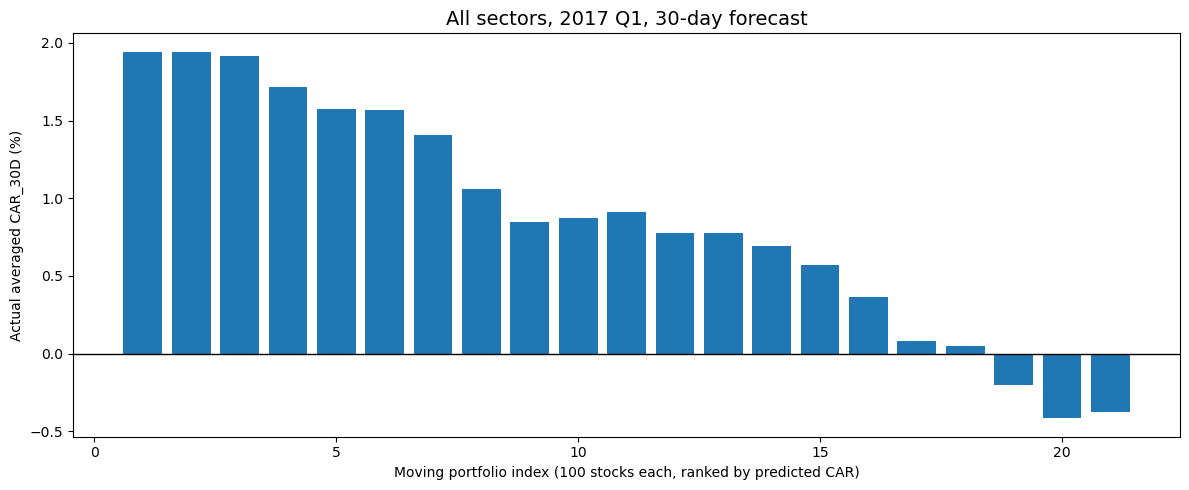


===== 2017 Q2 =====
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.1293594317722354
[GA-REG] best_params: {'max_depth': 7, 'learning_rate': 0.03, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.05}


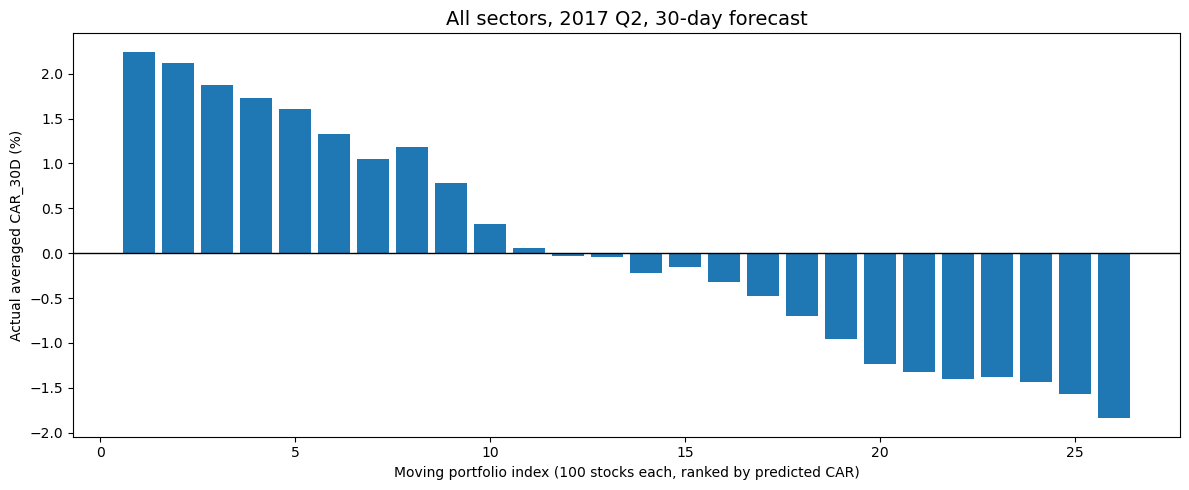


===== 2017 Q3 =====
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.12783411142524226
[GA-REG] best_params: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 2, 'gamma': 0.0}


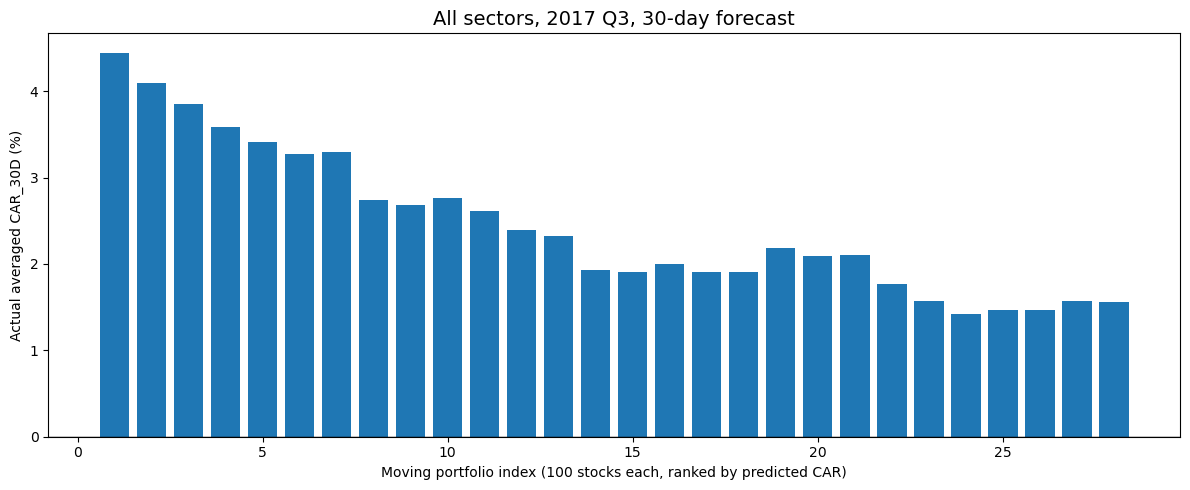


===== 2017 Q4 =====
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.12707638359426363
[GA-REG] best_params: {'max_depth': 6, 'learning_rate': 0.07, 'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'gamma': 0.01}


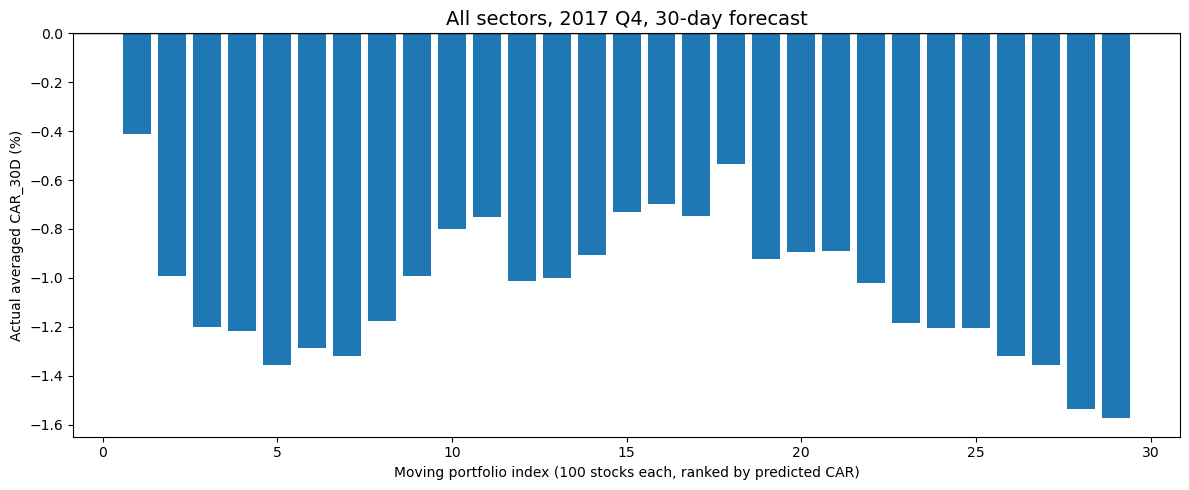


===== 2018 Q1 =====
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.12620154834736094
[GA-REG] best_params: {'max_depth': 7, 'learning_rate': 0.03, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0.0}


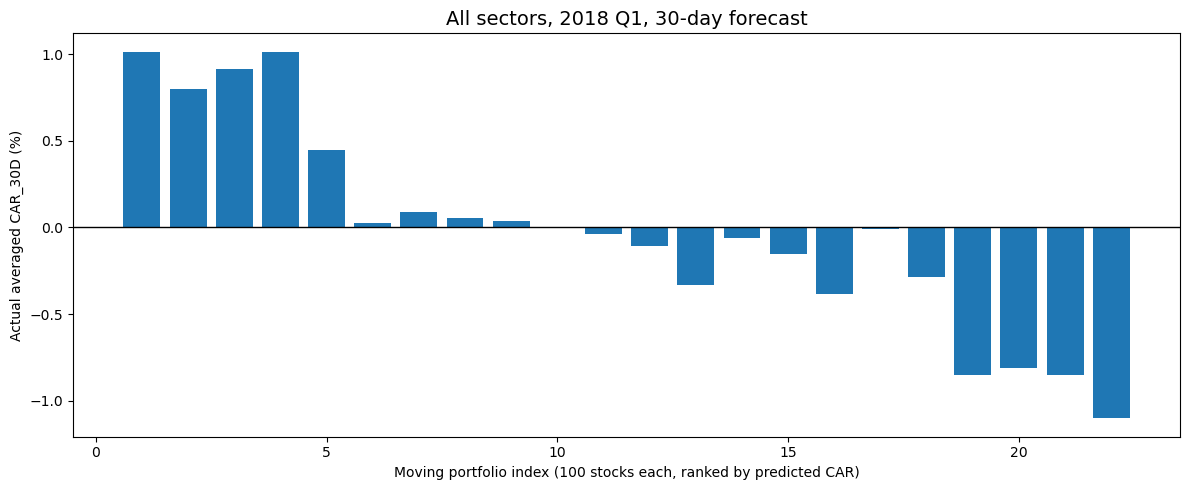


===== 2018 Q2 =====
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.12743268179503192
[GA-REG] best_params: {'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.9, 'min_child_weight': 7, 'gamma': 0.05}


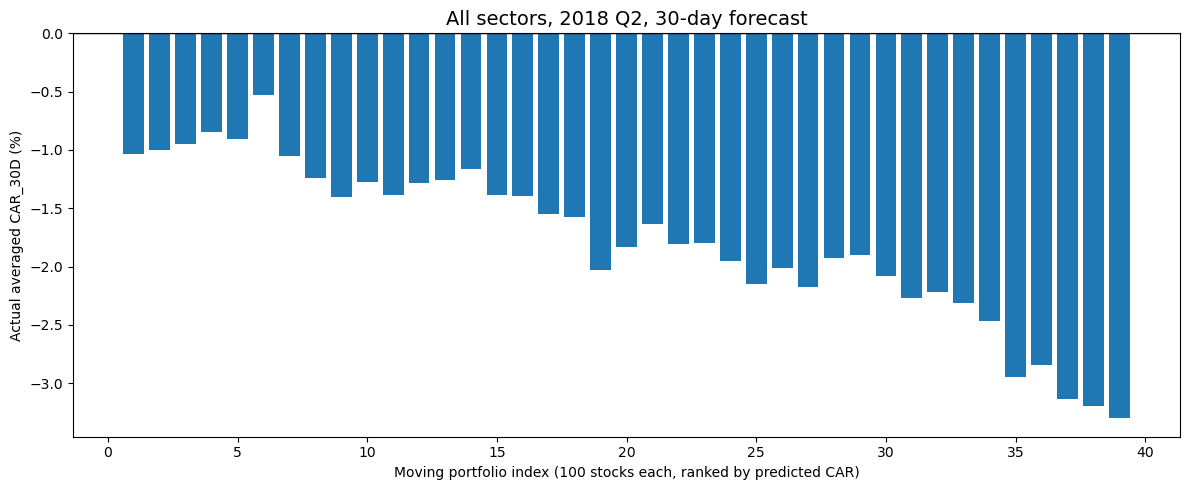


===== 2018 Q3 =====
[GA-REG] geração 1/5
[GA-REG] geração 2/5


KeyboardInterrupt: 

In [17]:

# -------------------- PLOT ESTILO FIG. 3 --------------------
def plot_curve_fig3(curve_df, year, quarter, save_path=None):
    plt.figure(figsize=(12, 5))
    plt.bar(curve_df["RankStart"], curve_df["AvgCAR30"] * 100)  # em %
    plt.axhline(0, linewidth=1, color="black")

    plt.title(f"All sectors, {year} Q{quarter}, 30-day forecast", fontsize=14)
    plt.xlabel("Moving portfolio index (100 stocks each, ranked by predicted CAR)", fontsize=10)
    plt.ylabel("Actual averaged CAR_30D (%)", fontsize=10)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=150)
    plt.show()

# -------------------- EXECUÇÃO COMPLETA DO PASSO A PASSO (2017–2019) --------------------

all_quants = []   # para consolidar Q1..Q5 de todos os trimestres

for year in YEARS:
    for quarter in [1, 2, 3, 4]:
        print(f"\n===== {year} Q{quarter} =====")
        df_q_sorted, curve_df, quant_df = run_quarter_portfolio_test(year, quarter, use_ga=True)

        if df_q_sorted is None:
            continue

        # Salva CSVs
        df_q_sorted.to_csv(
            os.path.join(CSV_DIR, f"events_sorted_{year}_Q{quarter}.csv"),
            index=False
        )
        curve_df.to_csv(
            os.path.join(CSV_DIR, f"moving_portfolios_{year}_Q{quarter}.csv"),
            index=False
        )
        quant_df.to_csv(
            os.path.join(CSV_DIR, f"quantiles_{year}_Q{quarter}.csv"),
            index=False
        )

        all_quants.append(quant_df)

        # Plota e salva figura tipo Fig. 3
        fig_path = os.path.join(FIG_DIR, f"fig3_style_{year}_Q{quarter}.png")
        plot_curve_fig3(curve_df, year, quarter, save_path=fig_path)

# Consolidado de Q1..Q5 de todos os trimestres
if all_quants:
    df_quants_all = pd.concat(all_quants, ignore_index=True)
    df_quants_all.to_csv(
        os.path.join(OUT_DIR, "quantiles_all_quarters.csv"),
        index=False
    )
    display(df_quants_all.head())
    print("\nArquivo de quantis consolidado salvo em:", 
          os.path.join(OUT_DIR, "quantiles_all_quarters.csv"))

print("\nConcluído. Resultados em:", OUT_DIR)


In [23]:
# -*- coding: utf-8 -*-
# === CONFIG BÁSICA (ajuste apenas se necessário) ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

BASE_PRE  = "pead_preproc"
TRAIN_CSV = os.path.join(BASE_PRE, "train_processed.csv")
TEST_CSV  = os.path.join(BASE_PRE,  "test_processed.csv")

OUT_DIR   = "results_6_2_rank"
os.makedirs(OUT_DIR, exist_ok=True)

# === Carrega o pré-processado e cria Year/Quarter ===
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)
df_all   = pd.concat([df_train, df_test], ignore_index=True)

df_all["EventTradeDate"] = pd.to_datetime(df_all["EventTradeDate"])
df_all["Year"]    = df_all["EventTradeDate"].dt.year
df_all["Quarter"] = df_all["EventTradeDate"].dt.quarter

# === (opcional) GA + CV (Fig. 2) para o REGRESSOR; pode desligar com use_ga=False ===
def ga_optimize_xgb_reg(X_train, y_train, generations=5, pop_size=10, verbose=False):
    """
    GA + 5-fold CV para XGBRegressor.
    Fitness = RMSE médio (quanto menor, melhor).
    Compatível com versões antigas do sklearn (sem parâmetro 'squared').
    """

    SEARCH_SPACE = {
        "max_depth":        [3,4,5,6,7],
        "learning_rate":    [0.01, 0.03, 0.05, 0.07, 0.1],
        "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
        "min_child_weight": [1,2,3,5,7],
        "gamma":            [0, 0.01, 0.05, 0.1, 0.2],
    }

    def random_params():
        return {k: np.random.choice(v) for k, v in SEARCH_SPACE.items()}

    def fitness(params):
        # KFold com embaralhamento para aproximar Fig.2 (GA + CV)
        kf = KFold(n_splits=5, shuffle=True)
        rmses = []

        for tr, va in kf.split(X_train):
            model = XGBRegressor(
                n_estimators=200,
                objective="reg:squarederror",
                **params
            )
            model.fit(X_train[tr], y_train[tr])
            pred = model.predict(X_train[va])
            # Versões antigas do sklearn não aceitam 'squared'; calculamos RMSE manualmente
            mse  = mean_squared_error(y_train[va], pred)
            rmse = np.sqrt(mse)
            rmses.append(rmse)

        return float(np.mean(rmses))  # menor é melhor

    # População inicial
    population = [random_params() for _ in range(pop_size)]

    for gen in range(generations):
        if verbose:
            print(f"[GA-REG] geração {gen+1}/{generations}", flush=True)

        scores = [fitness(p) for p in population]                 # RMSEs
        ranked = sorted(zip(scores, population), key=lambda x: x[0])
        survivors = [p for _, p in ranked[:pop_size // 2]]        # menores RMSE

        # Reprodução + mutação segura (mantém limites válidos do XGBoost)
        children = []
        while len(children) < pop_size - len(survivors):
            p1, p2 = np.random.choice(survivors, 2, replace=True)
            child = {k: (p1[k] if np.random.rand() < 0.5 else p2[k]) for k in SEARCH_SPACE}
            if np.random.rand() < 0.2:
                mk = np.random.choice(list(SEARCH_SPACE.keys()))
                child[mk] = np.random.choice(SEARCH_SPACE[mk])
            children.append(child)

        population = survivors + children

    # Escolhe o melhor (menor RMSE)
    final_scores = [fitness(p) for p in population]
    best_params  = population[int(np.argmin(final_scores))]
    if verbose:
        print("[GA-REG] melhor RMSE:", min(final_scores))
        print("[GA-REG] best_params:", best_params)
    return best_params

# === Função central: ranking por CAR_30D predito + gráfico com CAR_30D REAL ===
def rank_and_plot_quarter(year, quarter, use_ga=True, save=True, show=True):
    # Seleciona eventos do trimestre (test set daquele trimestre)
    mask_q = (df_all["Year"] == year) & (df_all["Quarter"] == quarter)
    df_q = df_all.loc[mask_q].copy()
    if df_q.empty:
        print(f"[{year} Q{quarter}] Sem eventos.")
        return None

    # Treino: tudo ANTES do início do trimestre (conforme o artigo)
    q_start = df_q["EventTradeDate"].min()
    df_hist = df_all[df_all["EventTradeDate"] < q_start].copy()
    if df_hist.empty:
        print(f"[{year} Q{quarter}] Sem histórico suficiente antes do trimestre.")
        return None

    # X, y
    X_tr = df_hist[FEATS].to_numpy()
    y_tr = df_hist["CAR_30D"].to_numpy()
    X_te = df_q[FEATS].to_numpy()

    # Hiperparâmetros (GA + CV Fig.2, ou defaults leves para depurar)
    if use_ga:
        params = ga_optimize_xgb_reg(X_tr, y_tr, generations=5, pop_size=10, verbose=True)
    else:
        params = {"max_depth":5,"learning_rate":0.05,"subsample":0.8,
                  "colsample_bytree":0.8,"min_child_weight":3,"gamma":0.05}

    # Modelo final e predição
    reg = XGBRegressor(n_estimators=300, objective="reg:squarederror", **params)
    reg.fit(X_tr, y_tr)
    df_q["CAR_pred"] = reg.predict(X_te)

    # RANKING: ordenar por CAR_30D predito (maior → menor)
    df_rank = df_q.sort_values("CAR_pred", ascending=False).reset_index(drop=True)
    df_rank["Rank"] = np.arange(1, len(df_rank)+1)

    # GRÁFICO: barras por ação (na ordem de ranking) usando CAR_30D REAL
    plt.figure(figsize=(12, 5))
    plt.bar(df_rank["Rank"], df_rank["CAR_30D"] * 100)  # em %
    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"Ranking por CAR_30D predito — Exibe CAR_30D REAL | {year} Q{quarter}", fontsize=13)
    plt.xlabel("Rank (ordenado por CAR_30D predito)", fontsize=10)
    plt.ylabel("CAR_30D REAL (%)", fontsize=10)
    plt.tight_layout()

    # salvar/mostrar
    if save:
        csv_path = os.path.join(OUT_DIR, f"ranking_{year}_Q{quarter}.csv")
        png_path = os.path.join(OUT_DIR, f"ranking_{year}_Q{quarter}.png")
        df_rank.to_csv(csv_path, index=False)
        plt.savefig(png_path, dpi=150)
        print("Salvos:", csv_path, "e", png_path)
    if show:
        plt.show()
    else:
        plt.close()

    return df_rank


In [ ]:
# === EXEMPLOS DE EXECUÇÃO ===
# Um trimestre específico (ex.: 2018 Q4)
rank_and_plot_quarter(2017, 2, use_ga=True)



In [24]:
# Todos os trimestres 2017–2019, em sequência:
for y in [2017, 2018, 2019]:
    for q in [1,2,3,4]:
        rank_and_plot_quarter(y, q, use_ga=True, save=True, show=False)
print("Concluído.")

[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.12884408456010188
[GA-REG] best_params: {'max_depth': 7, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 7, 'gamma': 0.01}
Salvos: results_6_2_rank\ranking_2017_Q1.csv e results_6_2_rank\ranking_2017_Q1.png
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.1281543997532137
[GA-REG] best_params: {'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'gamma': 0.0}
Salvos: results_6_2_rank\ranking_2017_Q2.csv e results_6_2_rank\ranking_2017_Q2.png
[GA-REG] geração 1/5
[GA-REG] geração 2/5
[GA-REG] geração 3/5
[GA-REG] geração 4/5
[GA-REG] geração 5/5
[GA-REG] melhor RMSE: 0.126143160123662
[GA-REG] best_params: {'max_depth': 7, 'learning_rate': 0.03, 'subsample': 0.9, 'colsample_bytree': 1.0, 'min

KeyboardInterrupt: 